In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import optuna
import optuna.visualization as vis

In [ ]:
df = pd.read_csv("/content/cleaned_data.csv")

df.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,reamining_contract,service_failure_count,download_avg,upload_avg,churn,download_over_limit_0,download_over_limit_1,download_over_limit_2,download_over_limit_3,download_over_limit_4,download_over_limit_5,download_over_limit_6,download_over_limit_7
0,1,0,4.669609,-0.544562,-0.334731,-0.781388,-0.265647,0,True,False,False,False,False,False,False,False
1,0,0,2.835973,-0.753378,-0.334731,-0.993761,-0.957871,1,True,False,False,False,False,False,False,False
2,1,0,3.175171,-0.753378,-0.334731,-0.647390,-0.687001,1,True,False,False,False,False,False,False,False
3,0,0,2.172325,-0.753378,0.910740,-0.993761,-0.957871,1,True,False,False,False,False,False,False,False
4,0,0,1.936361,-0.753378,-0.334731,-0.993761,-0.957871,1,True,False,False,False,False,False,False,False


In [ ]:
X = df.drop(columns=["churn"])

y = df["churn"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# **Logistic Regression**

In [ ]:
def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "none"])

    if penalty == "l1":
        solver = trial.suggest_categorical("solver_l1", ["saga"])
    elif penalty == "l2":
        solver = trial.suggest_categorical(
            "solver_l2", ["newton-cg", "lbfgs", "sag", "saga"]
        )
    else:  # penalty="none"
        solver = trial.suggest_categorical(
            "solver_none", ["newton-cg", "lbfgs", "sag", "saga"]
        )

    params = {
        "penalty": penalty,
        "solver": solver,
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "random_state": 42,
    }

    if penalty != "none":
        params["C"] = trial.suggest_float("C", 0.001, 100, log=True)

    try:
        model_log = LogisticRegression(**params)
        score = cross_val_score(model_log, X, y, cv=5, scoring="accuracy").mean()
        return score
    except:
        return 0


# Настройка Optuna
study = optuna.create_study(direction="maximize")

# Оптимізація
study.optimize(objective, n_trials=200, timeout=600, n_jobs=-1)

# Результати
print("Найкращі параметри:", study.best_params)
print("Найвища точність:", study.best_value)
# Візуалізація
vis.plot_optimization_history(study).show()

[I 2025-05-10 11:32:41,037] A new study created in memory with name: no-name-e4acd313-2929-4866-969a-e0bb96783d9b
[I 2025-05-10 11:32:48,659] Trial 1 finished with value: 0.8419834690276409 and parameters: {'penalty': 'l1', 'solver_l1': 'saga', 'max_iter': 797, 'C': 0.0032541453501988603}. Best is trial 1 with value: 0.8419834690276409.
[I 2025-05-10 11:32:48,728] Trial 2 finished with value: 0.0 and parameters: {'penalty': 'none', 'solver_none': 'lbfgs', 'max_iter': 903}. Best is trial 1 with value: 0.8419834690276409.
[I 2025-05-10 11:32:51,819] Trial 3 finished with value: 0.8457552879562578 and parameters: {'penalty': 'l2', 'solver_l2': 'newton-cg', 'max_iter': 125, 'C': 0.021108813173054422}. Best is trial 3 with value: 0.8457552879562578.
[I 2025-05-10 11:32:51,910] Trial 4 finished with value: 0.0 and parameters: {'penalty': 'none', 'solver_none': 'saga', 'max_iter': 803}. Best is trial 3 with value: 0.8457552879562578.
[I 2025-05-10 11:33:09,087] Trial 0 finished with value: 0.

Найкращі параметри: {'penalty': 'l1', 'solver_l1': 'saga', 'max_iter': 642, 'C': 90.61843831843768}
Найвища точність: 0.8469567223360611


# **Random Forest Classifier**

In [ ]:
def objective(trial):
    parameters = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,
        "n_jobs": -1,
    }

    model_rand = RandomForestClassifier(**parameters)
    scores = cross_val_score(model_rand, X, y, cv=5, scoring="accuracy")
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, timeout=600, n_jobs=-1)

print("Найкращі параметри:", study.best_params)
print("Найвища точність:", study.best_value)

vis.plot_optimization_history(study).show()

[I 2025-05-10 12:07:05,768] A new study created in memory with name: no-name-b3c97cb0-fa17-410b-b77d-d70fcc802ac7
[I 2025-05-10 12:07:39,190] Trial 0 finished with value: 0.8519201572473577 and parameters: {'n_estimators': 108, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8519201572473577.
[I 2025-05-10 12:08:07,205] Trial 1 finished with value: 0.9106330586699676 and parameters: {'n_estimators': 368, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.9106330586699676.
[I 2025-05-10 12:08:27,527] Trial 2 finished with value: 0.6262146529165392 and parameters: {'n_estimators': 81, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.9106330586699676.
[I 2025-05-10 12:08:28,438] Trial 3 finished with value: 0.82374189125981

Найкращі параметри: {'n_estimators': 368, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}
Найвища точність: 0.9106330586699676


# **XGBClassifier**

In [ ]:
def objective(trial):
    parameters = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "random_state": 42,
        "n_jobs": -1,
    }

    model_xgb = XGBClassifier(**parameters)
    scores = cross_val_score(model_xgb, X, y, cv=5, scoring="accuracy")
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, timeout=600, n_jobs=-1)

print("Найкращі параметри:", study.best_params)
print("Найвища точність:", study.best_value)

vis.plot_optimization_history(study).show()

[I 2025-05-09 22:54:22,892] A new study created in memory with name: no-name-4515d176-8d65-4914-a216-ea7cf13eb65c
[I 2025-05-09 22:54:30,722] Trial 1 finished with value: 0.5969606450111193 and parameters: {'n_estimators': 242, 'max_depth': 7, 'learning_rate': 0.05871798366911495, 'subsample': 0.7059065972188527, 'colsample_bytree': 0.9866733812066949, 'gamma': 3.2497460893639523, 'reg_alpha': 0.852446666636979, 'reg_lambda': 1.8949877855549058}. Best is trial 1 with value: 0.5969606450111193.
[I 2025-05-09 22:54:39,312] Trial 0 finished with value: 0.5346527377744611 and parameters: {'n_estimators': 370, 'max_depth': 15, 'learning_rate': 0.0069904825452290825, 'subsample': 0.9834650896910084, 'colsample_bytree': 0.6742822802999394, 'gamma': 4.604080890281094, 'reg_alpha': 1.0020503592212227, 'reg_lambda': 1.3222704932328477}. Best is trial 1 with value: 0.5969606450111193.
[I 2025-05-09 22:54:44,537] Trial 2 finished with value: 0.6112663169865316 and parameters: {'n_estimators': 368,

Найкращі параметри: {'n_estimators': 117, 'max_depth': 3, 'learning_rate': 0.004258982279500132, 'subsample': 0.7697889004151411, 'colsample_bytree': 0.9068500807464871, 'gamma': 0.1492242146705568, 'reg_alpha': 9.070732132847755, 'reg_lambda': 0.9693578016537738}
Найвища точність: 0.8583185359686762


# **CatBoostClassifier**

0:	test: 0.9450108	best: 0.9450108 (0)	total: 21.8ms	remaining: 10.9s
100:	test: 0.9670863	best: 0.9670863 (100)	total: 4.56s	remaining: 18s
200:	test: 0.9679895	best: 0.9680401 (175)	total: 7.7s	remaining: 11.5s
300:	test: 0.9685460	best: 0.9685795 (295)	total: 10.2s	remaining: 6.76s
400:	test: 0.9686596	best: 0.9687337 (341)	total: 12.8s	remaining: 3.15s
499:	test: 0.9686428	best: 0.9687337 (341)	total: 15.2s	remaining: 0us

bestTest = 0.9687337318
bestIteration = 341

Shrink model to first 342 iterations.
AUC-ROC на тренувальній вибірці: 0.9774
AUC-ROC на тестовій вибірці: 0.9687
F1-score на тренувальній вибірці: 0.9464
F1-score на тестовій вибірці: 0.9410
Confusion Matrix (тренувальна вибірка):
[[24211  1289]
 [ 2072 29692]]
Confusion Matrix (тестова вибірка):
[[6076  364]
 [ 554 7323]]

Важливість ознак:
                        feature  importance
3            reamining_contract   53.348748
5                  download_avg   19.211656
2              subscription_age   12.320014
6  

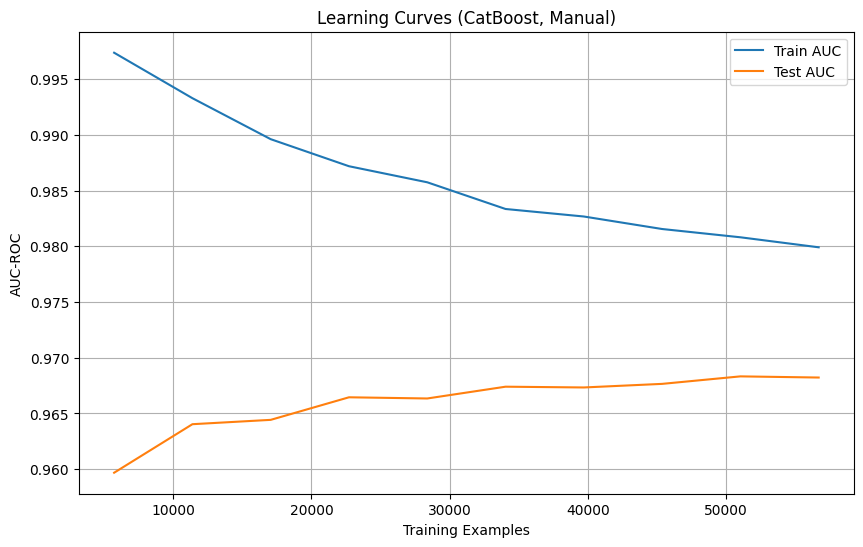

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from catboost import CatBoostClassifier, Pool, cv
import matplotlib.pyplot as plt

model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    auto_class_weights="Balanced",
    verbose=100,
    eval_metric="AUC",
)

# Навчання з оцінкою на тестовій вибірці
model_cat.fit(X_train, y_train, eval_set=(X_test, y_test))

y_train_pred_proba = model_cat.predict_proba(X_train)[:, 1]
y_test_pred_proba = model_cat.predict_proba(X_test)[:, 1]
y_train_pred = model_cat.predict(X_train)
y_test_pred = model_cat.predict(X_test)

# Обчислення AUC-ROC
auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)
print(f"AUC-ROC на тренувальній вибірці: {auc_train:.4f}")
print(f"AUC-ROC на тестовій вибірці: {auc_test:.4f}")

# Обчислення F1-score і Confusion Matrix
print(f"F1-score на тренувальній вибірці: {f1_score(y_train, y_train_pred):.4f}")
print(f"F1-score на тестовій вибірці: {f1_score(y_test, y_test_pred):.4f}")
print("Confusion Matrix (тренувальна вибірка):")
print(confusion_matrix(y_train, y_train_pred))
print("Confusion Matrix (тестова вибірка):")
print(confusion_matrix(y_test, y_test_pred))

# Важливість ознак
feature_importance = pd.DataFrame(
    {"feature": X.columns, "importance": model.get_feature_importance()}
).sort_values(by="importance", ascending=False)
print("\nВажливість ознак:")
print(feature_importance)

# Крос-валідація
pool = Pool(X, y)
params = {
    "iterations": 500,
    "learning_rate": 0.1,
    "depth": 6,
    "auto_class_weights": "Balanced",
    "loss_function": "Logloss",
    "eval_metric": "AUC",
}
cv_results = cv(pool, params, fold_count=5, verbose=100)
print(
    f"\nСереднє AUC-ROC на крос-валідації: {cv_results['test-AUC-mean'].iloc[-1]:.4f}"
)
print(f"Стандартне відхилення AUC-ROC: {cv_results['test-AUC-std'].iloc[-1]:.4f}")

# Криві навчання — побудова вручну
fractions = np.linspace(0.1, 0.99, 10)  # Змінили 1.0 на 0.99
train_scores, test_scores = [], []

for frac in fractions:
    X_frac, _, y_frac, _ = train_test_split(
        X_train, y_train, train_size=frac, stratify=y_train, random_state=42
    )

    model_frac = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        auto_class_weights="Balanced",
        verbose=0,
    )
    model_frac.fit(X_frac, y_frac)

    y_frac_pred = model_frac.predict_proba(X_frac)[:, 1]
    y_test_pred = model_frac.predict_proba(X_test)[:, 1]

    train_scores.append(roc_auc_score(y_frac, y_frac_pred))
    test_scores.append(roc_auc_score(y_test, y_test_pred))

# Побудова графіка
train_sizes = [int(frac * len(X_train)) for frac in fractions]

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, label="Train AUC")
plt.plot(train_sizes, test_scores, label="Test AUC")
plt.xlabel("Training Examples")
plt.ylabel("AUC-ROC")
plt.title("Learning Curves (CatBoost, Manual)")
plt.legend()
plt.grid()

score = cross_val_score(model_cat, X, y, cv=5, scoring="accuracy").mean()
print("Значення крос-валідації:", score)

# **Оцінювання Random Forest Classifier та Catboost Classifier**



```
# This is formatted as code
```

За допомогою Optuna (автоматичний підбір параметрів) протестували 3 моделі та робимо висновок, що Random Forest Classifier та CatBoost Classifier мають найвищу точність, але Catboost має більше перенавчання

In [ ]:
rf = RandomForestClassifier(
    n_estimators=368,
    max_depth=3,
    min_samples_split=14,
    min_samples_leaf=9,
    max_features="sqrt",
    bootstrap=False,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      6440
           1       0.95      0.93      0.94      7877

    accuracy                           0.93     14317
   macro avg       0.93      0.93      0.93     14317
weighted avg       0.93      0.93      0.93     14317



In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    auto_class_weights="Balanced",
    verbose=100,
    eval_metric="AUC",
)

model_cat.fit(X_train, y_train)
y_pred = model_cat.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"f1: {f1:.4f}")

0:	total: 121ms	remaining: 1m
100:	total: 4.71s	remaining: 18.6s
200:	total: 8.55s	remaining: 12.7s
300:	total: 12.6s	remaining: 8.33s
400:	total: 15.2s	remaining: 3.74s
499:	total: 17.9s	remaining: 0us
Accuracy: 0.9358
Precision: 0.9522
Recall: 0.9300
f1: 0.9410
